# Neural Network Class Defination 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit, logit

class Neural_Network:

    def __init__(self, INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES, LEARNING_RATE):
        """initialize the neural network"""

        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = INPUT_NODES
        self.hidden_nodes = HIDDEN_NODES
        self.output_nodes = OUTPUT_NODES

        # Set the learnig rate
        self.learning_rate = LEARNING_RATE

        # Activion Function.
        self.activtion_function = lambda x : expit(x)

        # Inverse activation function.
        self.inverse_activation_function = lambda x : logit(x)

        # Set random weights
        self.weigths_input_to_hidden_layer = np.random.default_rng().normal(0, pow(self.input_nodes, -0.5),
                                                          (self.hidden_nodes, self.input_nodes))
        self.weigths_hidden_to_output_layer = np.random.default_rng().normal(0, pow(self.hidden_nodes, -0.5),
                                                          (self.output_nodes, self.hidden_nodes))

    def train(self, input_list, target_list):
        """train the neural network"""
        
        # calculate signals into hidden layer
        inputs = np.array(input_list, ndmin=2).T # ndmin D-2 

        x_hidden = np.dot(self.weigths_input_to_hidden_layer, inputs)
        o_hidden = self.activtion_function(x_hidden)

        x_output = np.dot(self.weigths_hidden_to_output_layer, o_hidden)
        o_output = self.activtion_function(x_output)

        # calculate the error
        targets = np.array(target_list, ndmin=2).T
        output_errors = targets - o_output

        # calculate the error term for the hidden layer
        hidden_errors = np.dot(self.weigths_hidden_to_output_layer.T, output_errors)

        # update the weights with Gradient Descent
        self.weigths_hidden_to_output_layer += self.learning_rate * np.dot((output_errors * o_output * (1 - o_output)), o_hidden.T)
        self.weigths_input_to_hidden_layer += self.learning_rate * np.dot((hidden_errors * o_hidden * (1 - o_hidden)), inputs.T)

    def query(self, input_list):
        """query the neural network"""

        # set the input to array 2x2
        inputs = np.array(input_list, ndmin=2).T

        # calculate signals into hidden layer
        x_hiddem = np.dot(self.weigths_input_to_hidden_layer, inputs)
        o_hidden = self.activtion_function(x_hiddem)

        # calculate signals into output layer
        x_output = np.dot(self.weigths_hidden_to_output_layer, o_hidden)
        o_output = self.activtion_function(x_output)

        return o_output
         
    def reversequery(self, targets_list):
        """reverse query the neural network"""

        o_output = np.array(targets_list, ndmin=2).T

        # output layer to hidden layer
        x_output = self.inverse_activation_function(o_output)
        o_hidden = np.dot(self.weigths_hidden_to_output_layer.T, x_output)

        # scale data to reverse function to hidden layer
        o_hidden -= np.min(o_hidden)
        o_hidden /= np.max(o_hidden)
        o_hidden *= 0.98
        o_hidden += 0.01

        # hidden layer to input layer
        x_hidden = self.inverse_activation_function(o_hidden)
        inputs = np.dot(self.weigths_input_to_hidden_layer.T, x_hidden)

        # scale data to reverse function to input layer
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01

        return inputs
        

# Neural Network Instance Creation

In [2]:
# import data Training
train_file = open('data/mnist_train.csv', 'r')
train_list = train_file.readlines()
train_file.close()

# import data testing
test_file = open('data/mnist_test.csv', 'r')
test_list = test_file.readlines()
test_file.close()

# Train NN

In [3]:
# Set the input nodes, hidden nodes and output nodes.
def training(input_nodes=784, hidden_nodes=200, output_nodes=10, learning_rate=0.1, epochs=4):
    """train the NN with custom input. 
    default input_nodes=784, hidden_nodes=200, output_nodes=10, learning_rate=0.1, epochs=4"""

    # init NN
    global nn
    nn = Neural_Network(input_nodes, hidden_nodes, output_nodes, learning_rate)
    
    # Train the neural network
    for e in range(epochs):
        for row in train_list:
            row_data = row.split(',')
            # scale between 0.01 and 0.98
            inputs = (np.asfarray(row_data[1:]) / (255.0 * 0.98)) + 0.01
            targets = np.zeros(output_nodes) + 0.01
            targets[int(row_data[0])] = 0.99
            nn.train(inputs, targets)

In [8]:
training()

# Query NN

In [3]:
def querying(raw_score=False): 
    """test the neural network with taring data and get performance
    two return values: 1. accuracy of the NN 2. Performane of each number"""

    score = []
    score_each_number = [[],[],[],[],[],[],[],[],[],[]]
    each_number_prec = [0,0,0,0,0,0,0,0,0,0]

    for row in test_list:
        row_data = row.split(',')
        target_numebr = int(row_data[0])
        inputs =(np.asfarray(row_data[1:]) / (255.0 * 0.98)) + 0.01
        outputs = nn.query(inputs)
        predicted_number = np.argmax(outputs)

        if(target_numebr == predicted_number):
            score.append(1)
        else:
            score.append(0)

        for i in range(10):
            if target_numebr == i:
                if (target_numebr == predicted_number):
                    score_each_number[i].append(1)
                else:
                    score_each_number[i].append(0)

    score_array = np.asfarray(score)
    score_array_percent = (score_array.sum() / score_array.size) * 100

    sum_s = 0
    for i in range(10):
        for j in range(len(score_each_number[i])):
            sum_s += score_each_number[i][j]
        each_number_prec[i] = round((sum_s / len(score_each_number[i])) * 100, 2)
        sum_s = 0

    if raw_score == False:
        return score_array_percent, each_number_prec
    elif raw_score == True:
        return score_array_percent, each_number_prec, score_array, score_each_number


In [57]:
acc, per_each_num, score_array, each_array = querying(raw_score=True)

print('\nNet Performance: ', acc, '%')
print('---------------------------------------------------')
for i in range(10):
    print('\nNumber: ',i,' Performance: ', per_each_num[i], '%', 'n=', len(each_array[i]))



Net Performance:  97.28999999999999 %
---------------------------------------------------

Number:  0  Performance:  98.98 % n= 980

Number:  1  Performance:  98.77 % n= 1135

Number:  2  Performance:  97.29 % n= 1032

Number:  3  Performance:  97.52 % n= 1010

Number:  4  Performance:  97.66 % n= 982

Number:  5  Performance:  95.96 % n= 892

Number:  6  Performance:  97.29 % n= 958

Number:  7  Performance:  95.72 % n= 1028

Number:  8  Performance:  96.1 % n= 974

Number:  9  Performance:  97.32 % n= 1009


Target number is:  7
----------------------------------------
Predicted number of  0  is:  0.524 %
Predicted number of  1  is:  0.761 %
Predicted number of  2  is:  0.968 %
Predicted number of  3  is:  0.727 %
Predicted number of  4  is:  0.817 %
Predicted number of  5  is:  0.777 %
Predicted number of  6  is:  1.194 %
Predicted number of  7  is:  98.53 %
Predicted number of  8  is:  0.495 %
Predicted number of  9  is:  0.790 %


C:\Users\HekmatnezhAd\AppData\Local\Temp\ipykernel_33448\3530833167.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = str(float(predicted_number[pre] * 100))


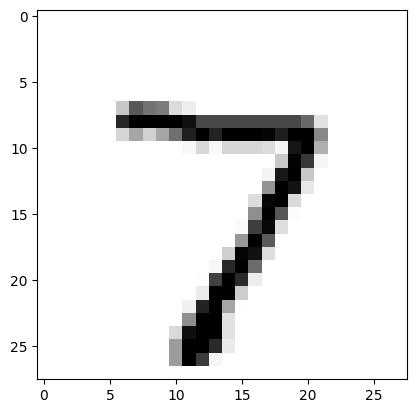

In [96]:
# test the neural network with a test data 
# choose one of a test data and print
test_row_data = test_list[0].split(',')
print('Target number is: ', test_row_data[0])
image_data = np.asfarray(test_row_data[1:]).reshape((28,28))
image = plt.imshow(image_data, cmap='Greys')

# show predicted number
predicted_number = nn.query((np.asfarray(test_row_data[1:]) / (255.0 * 0.98)) + 0.01)
print('----------------------------------------')

for pre in range(len(predicted_number)):
    val = str(float(predicted_number[pre] * 100))
    print('Predicted number of ',pre, ' is: ', val[:5],'%')


# optimization

# find better Learning Rate

In [ ]:
# It takes a long time to run this cell
# for me, ~26 minutes

tested_learning_rate = [0.01, 0.1, 0.2, 0.3, 0.6]
# hidden_nodes=200, epochs=4
performance = []


for lr in tested_learning_rate:
    training(learning_rate=lr)
    acc, num = querying()
    performance.append(acc)
    
print(performance)
# plot
fig, ax = plt.subplots()
ax.plot(tested_learning_rate, performance, linestyle='--', marker='o')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Performance (%)')
ax.set_title('Learning Rate vs Performance')

plt.show() 

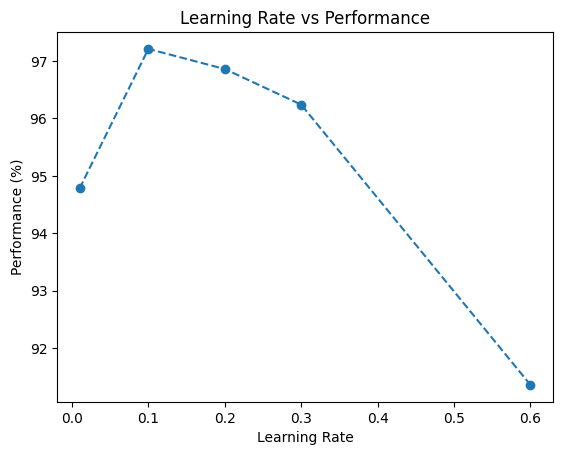

In [27]:
# This result comes up from the cell when testing

tested_learning_rate = [0.01, 0.1, 0.2, 0.3, 0.6]
performance = [94.78, 97.21, 96.86, 96.24000000000001, 91.36]

fig, ax = plt.subplots()
ax.plot(tested_learning_rate, performance, linestyle='--', marker='o')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Performance (%)')
ax.set_title('Learning Rate vs Performance')

plt.show()

# find better Epoch 

In [ ]:
# It takes a long time to run this cell
# for me, ~59 minutes
epoch_list = [1, 2, 3, 4, 5, 7, 10, 20]
# hidden_nodes=200, learning_rate=0.1
performance = []

for e in epoch_list:
    training(epochs=e)
    acc, num = querying()
    performance.append(acc)
    
print(performance)

# plot
fig, ax = plt.subplots()
ax.plot(epoch_list, performance, linestyle='--', marker='o')
ax.set_xlabel('Epochs')
ax.set_ylabel('Performance (%)')
ax.set_title('Epochs vs Performance')

plt.show()

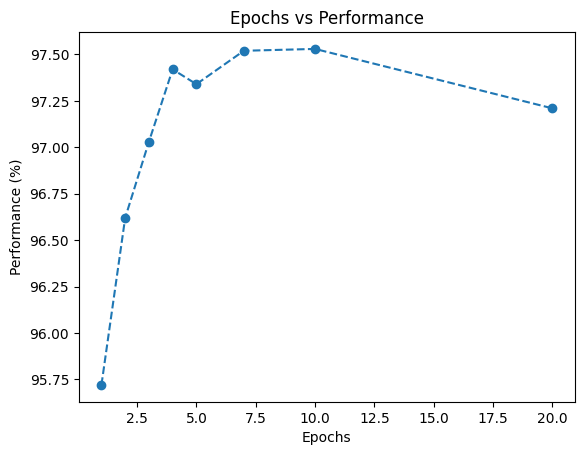

In [31]:
# This result comes up from the cell when testing
epoch_list = [1, 2, 3, 4, 5, 7, 10, 20]
performance_list = [95.72, 96.61999999999999, 97.03, 97.42, 97.34, 97.52, 97.53, 97.21]
fig, ax = plt.subplots()
ax.plot(epoch_list, performance_list, linestyle='--', marker='o')
ax.set_xlabel('Epochs')
ax.set_ylabel('Performance (%)')
ax.set_title('Epochs vs Performance')

plt.show()

# find better Hidden Nodes

In [ ]:
# It takes a long time to run this cell
# for me,  ~41 minutes
hidden_nodes_list = [10, 100, 200, 250, 500, 1000]
# learning_rate=0.1, epochs=4
performance = []

for hnl in hidden_nodes_list:
    training(hidden_nodes=hnl)
    acc, num = querying()
    performance.append(acc)
    
print(performance)

# plot
fig, ax = plt.subplots()
ax.plot(hidden_nodes_list, performance, linestyle='--', marker='o')
ax.set_xlabel('Hidden Nodes')
ax.set_ylabel('Performance (%)')
ax.set_title('Hidden Nodes vs Performance')

plt.show()

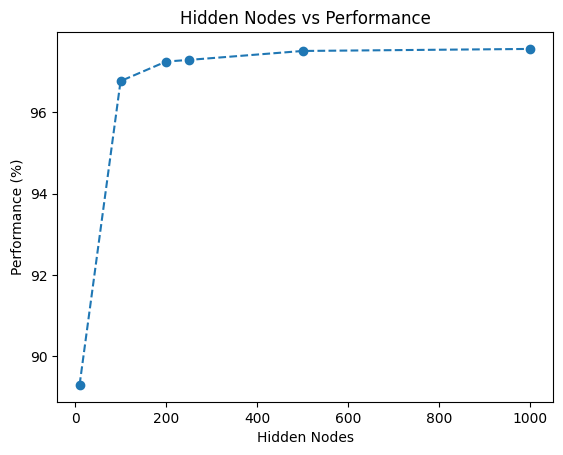

In [35]:
# This result comes up from the cell when testing
h_nodes_list = [10, 100, 200, 250, 500, 1000]
performance_list = [89.3, 96.76, 97.24000000000001, 97.28, 97.5, 97.55]

fig, ax = plt.subplots()
ax.plot(h_nodes_list, performance_list, linestyle='--', marker='o')
ax.set_xlabel('Hidden Nodes')
ax.set_ylabel('Performance (%)')
ax.set_title('Hidden Nodes vs Performance')

plt.show()

# Predicting our own images using the NN

In [8]:
# import our image 
import imageio
import os


path = 'img'
my_imgs_path = os.listdir(path=path)
for i in my_imgs_path:
    j = 'img/' + i
    my_imgs_path[my_imgs_path.index(i)] = j
our_own_data = []
  
for img_file_name in my_imgs_path:

    label = int(img_file_name[4])
    print(label,' loading...', img_file_name)

    img_array = imageio.imread(img_file_name, mode='F')

    img_data = 255.0 - img_array.reshape(784)

    img_data = (img_data / 255.0 * 0.98) + 0.01

    record = np.append(label, img_data)
    our_own_data.append(record)

2  loading... img/2_1.png
3  loading... img/3_1.png
4  loading... img/4_1.png
5  loading... img/5_1.png
5  loading... img/5_2.png
6  loading... img/6_1.png
6  loading... img/6_2.png
6  loading... img/6_3.png
9  loading... img/9_1.png


C:\Users\HekmatnezhAd\AppData\Local\Temp\ipykernel_9168\412002154.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_array = imageio.imread(img_file_name, mode='F')


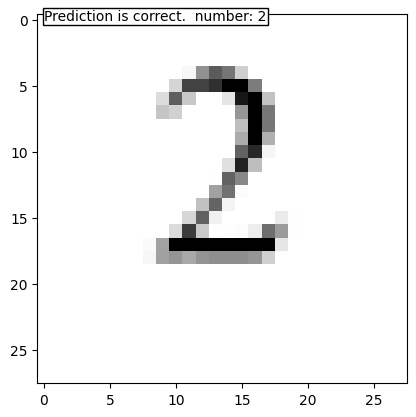

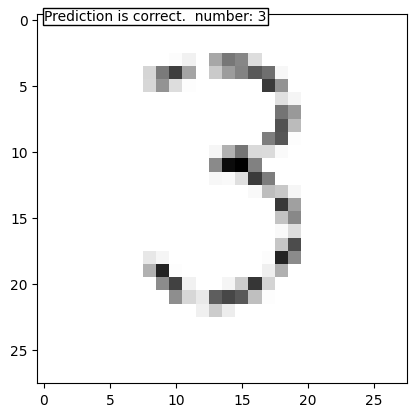

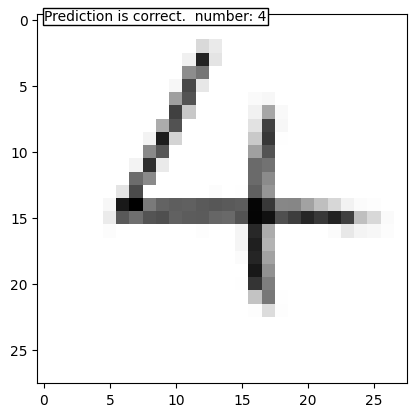

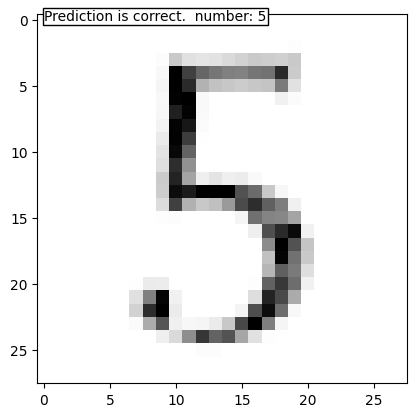

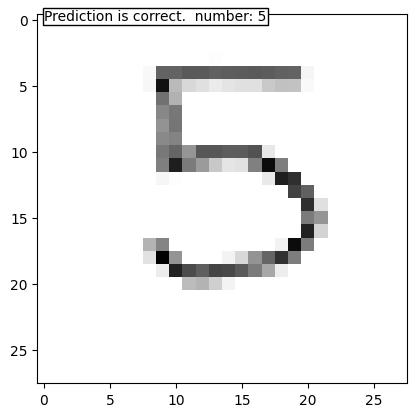

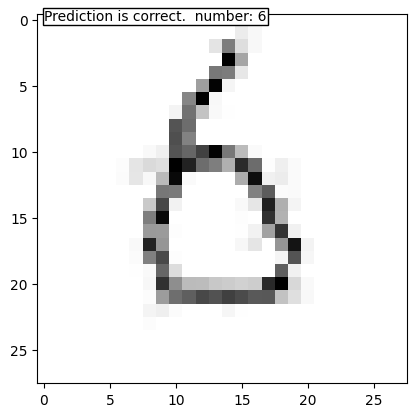

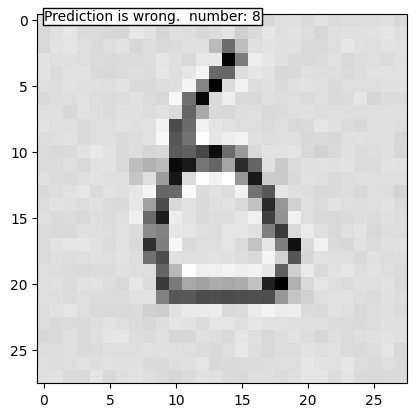

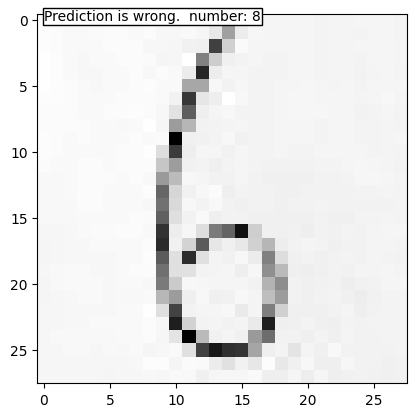

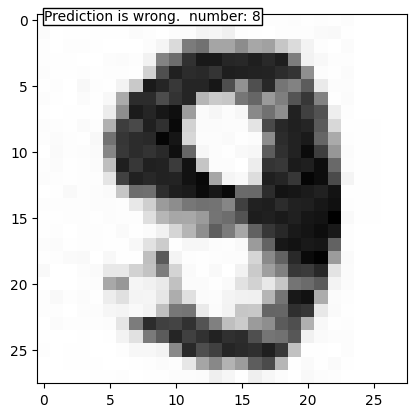

acc:  66.67 %


In [ ]:
# prediction our own images

score = []
# choose one of a image 
for item in range(len(our_own_data)):

    # the correct answer
    correct_label = our_own_data[item][0]
    # data of image
    inputs = our_own_data[item][1:]

    outputs = nn.query(inputs)

    label = np.argmax(outputs)
    if (label == correct_label):
        answer = 'Prediction is correct.  number: ' + str(label)
        score.append(1)
    else:
        answer = 'Prediction is wrong.  number: ' + str(label)
        score.append(0)

    plt.text(0, 0, answer, bbox={'facecolor': 'white', 'pad': 1})
    plt.imshow(our_own_data[item][1:].reshape(28,28), cmap='Greys', interpolation='None')
    plt.show()
final_score = np.asfarray(score)
print('acc: ', round(final_score.sum() / final_score.size * 100, 2), '%')

# Black Box of the NN

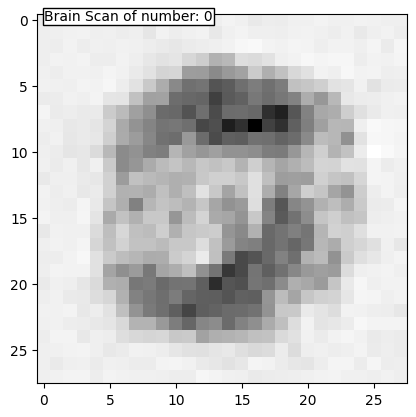

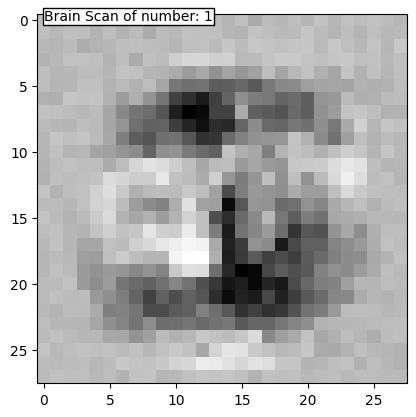

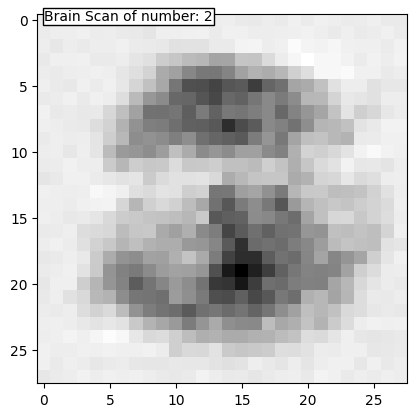

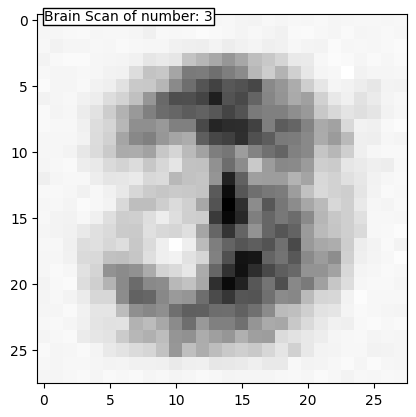

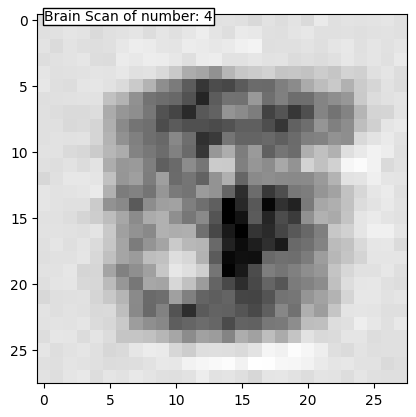

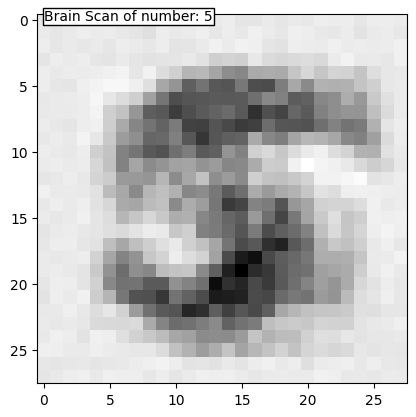

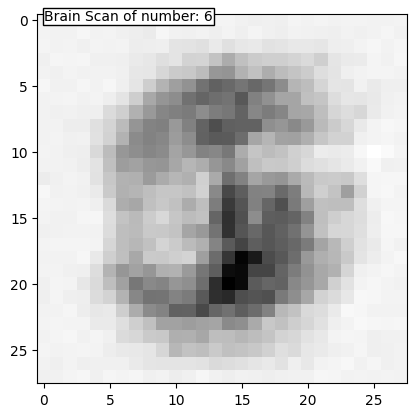

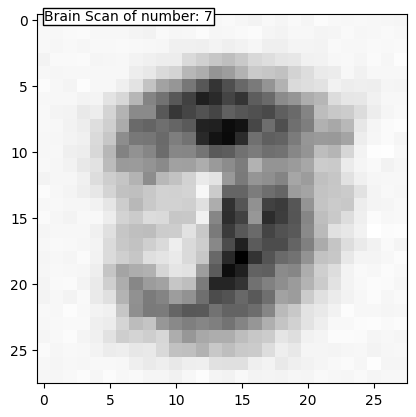

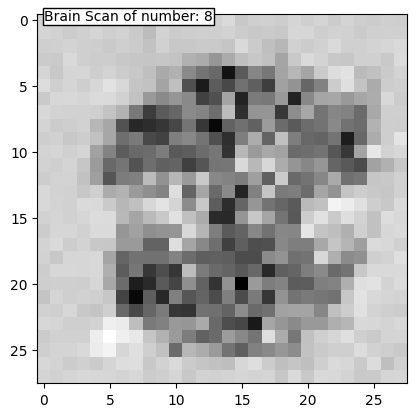

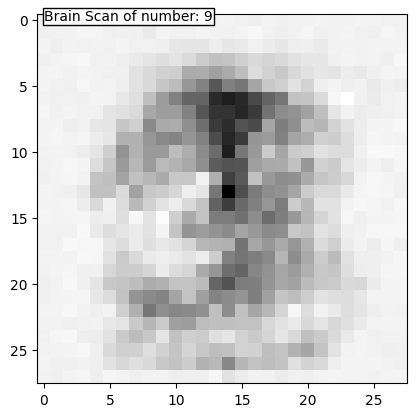

In [6]:
label = [i for i in range(10)]
output_nodes = 10

for i in label:
    targets_list = np.zeros(output_nodes) + 0.01
    targets_list[i] = 0.99

    image_array = nn.reversequery(targets_list)


    l = 'Brain Scan of number: ' + str(i)
    plt.text(0, 0, l, bbox={'facecolor': 'white', 'pad': 1})
    plt.imshow(image_array.reshape((28,28)), label=l, cmap='Greys')
    
    plt.show()



# Manually find better resualt

In [98]:
lr = 0.07
e = 5
hn = 600
training(learning_rate=lr, epochs=e, hidden_nodes=hn)
acc, eachnum = querying()

print('\nNet Performance: ', acc, '%')
print('---------------------------------------------------')
for i in range(10):
    print('\nNumber: ',i,' Performance: ', eachnum[i], '%')


Net Performance:  97.53 %
---------------------------------------------------

Number:  0  Performance:  99.08 %

Number:  1  Performance:  99.3 %

Number:  2  Performance:  96.8 %

Number:  3  Performance:  98.32 %

Number:  4  Performance:  97.25 %

Number:  5  Performance:  96.52 %

Number:  6  Performance:  97.7 %

Number:  7  Performance:  95.33 %

Number:  8  Performance:  97.54 %

Number:  9  Performance:  97.22 %


# Save and Laod tested Weights

In [ ]:
np.save('saved_weights/weights_input_to_hidden_layer.npy', nn.weigths_input_to_hidden_layer)
np.save('saved_weights/weights_hidden_to_output_layer.npy', nn.weigths_hidden_to_output_layer)
a = []
a.append(nn.hidden_nodes)
a.append(nn.learning_rate)
np.save('saved_weights/hyper_parameters.npy', a)

In [ ]:
a = np.load('saved_weights/hyper_parameters.npy')
hn = int(a[0])
lr = int(a[1])
inp = 784
outp = 10
nn = Neural_Network(inp, hn, outp, lr)
nn.weigths_input_to_hidden_layer = np.load('saved_weights/weights_input_to_hidden_layer.npy')
nn.weigths_hidden_to_output_layer = np.load('saved_weights/weights_hidden_to_output_layer.npy')